In [1]:
import sys
sys.path.append('../')
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mc
from matplotlib.colors import LinearSegmentedColormap
import fitz  # PyMuPDF
from PIL import Image
import io
import colorsys
from colour import Color
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel, RotationOperator
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'
def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp
font_size = 20
axis = [0,0,1]

NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025
NUM_D = 50

# Cubic solid cut off from Nickel (length=1)
nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
axis = [0,0,1]
origin = nickel.xyz.mean(axis=0)
rotation_op = RotationOperator(axis=axis, origin=origin)
method = 'JS'

atoms_idx_center = np.any(nickel.xyz == nickel.lattice.a/2, axis=1)
unique_rows, indices = np.unique(nickel.xyz[atoms_idx_center], axis=0, return_index=True)
atoms_idx_center = np.where(atoms_idx_center)[0][indices]
atoms_idx_corner = np.setdiff1d(np.arange(nickel.xyz.shape[0]), atoms_idx_center)

# The violation of symmetry elements of local distorted Nickel

In [2]:
def perturbation_arr(deviation_angle, radius=1):
    if deviation_angle == 0:
        dir = np.array([[1, 0, 0], [np.sqrt(2)/2, np.sqrt(2)/2, 0]])
    elif deviation_angle == 45:
        dir = np.array([[np.sqrt(2)/2, 0, np.sqrt(2)/2], [1/2, 1/2, np.sqrt(2)/2]])
    elif deviation_angle == 90:
        dir = np.array([[0, 0, 1]])
    result = dir * radius
    return result

def initiate_distorted_nickel(idx, perturbation_dir, disp):
    nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel.xyz
    xyz_distorted[idx,:3] += perturbation_dir * disp
    nickel.set_xyz(xyz_distorted)
    return nickel

def calc_variance_sample_size_from_nickel(nickel_structure, op, method, **operator_kwrgs):
    sample_size, _ = nickel_structure.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method=method,
        **operator_kwrgs
        )
    return sample_size

def compute_sbm_C4(args):
    idx, perturbation, disp = args
    nickel_structure = initiate_distorted_nickel(idx, perturbation, disp)
    measure = 0
    for angle in [90, 180, 270]:
        sample_size = calc_variance_sample_size_from_nickel(nickel_structure, rotation_op, method=method, angle=angle)
        measure += nickel_structure.calc_symmetry_breaking_measure(
                num_samples=sample_size,
                operator=rotation_op,
                method=method, 
                angle=angle
            )
    return [disp, measure/3]
    
def construct_tasks(disp_list, atoms_idx_set, deviation_angle):
    tasks = []
    perturbations = perturbation_arr(deviation_angle)
    for idx in atoms_idx_set:
        for perturbation in perturbations:
            for disp in disp_list:
                tasks.append((idx, perturbation, disp))
    return tasks

def compute_sbm_multiprocessing(
    max_disp,
    center,
    save_filedir: str = None
):
    disp_list = np.linspace(0, max_disp, int(NUM_D * max_disp))
    measures = []
    if center:
        atoms_idx_set = atoms_idx_center
    else:
        atoms_idx_set = atoms_idx_corner
    for deviation_angle in tqdm([0, 45, 90]):
        tasks = construct_tasks(disp_list, atoms_idx_set, deviation_angle)
        with Pool(processes=cpu_count()) as pool:
            measures_deviation_angle = list(tqdm(pool.imap(compute_sbm_C4, tasks), total=len(tasks)))
        measures.append(measures_deviation_angle)
    if save_filedir:
        # Row in saved file: d, measure
        np.savetxt(save_filedir, measures, delimiter=',') 
    return measures

In [5]:
# Center atoms
measures_data_center_0, measures_data_center_45, measures_data_center_90 = compute_sbm_multiprocessing(max_disp=4, center=True, save_filedir=None)

100%|██████████| 3/3 [13:05<00:00, 261.73s/it]


In [4]:
# Corner atoms
measures_data_corner_0, measures_data_corner_45, measures_data_corner_90 = compute_sbm_multiprocessing(max_disp=3, center=False, save_filedir=None)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [12:24<00:00, 248.15s/it]


# Paper Section 5.1.2 - Plot

In [3]:
def convert_pdf_to_image(pdf_path, page_number=0, zoom=2.0):
    # Open the PDF file
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # Get the page (0-based index)
    # Convert the page to an image
    matrix = fitz.Matrix(zoom, zoom)  # Zoom factor for higher resolution
    pix = page.get_pixmap(matrix=matrix)
    # Convert the Pixmap object to a PIL Image
    image = Image.open(io.BytesIO(pix.tobytes("png")))
    doc.close()
    return image

def plot(data, xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None, solid=None, extra_data=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 4)
    plt.style.use(style)
    # Enable LaTeX text rendering with a custom preamble for sans-serif fonts
    rc('text', usetex=True)
    plt.rcParams.update({
        'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
    })
    
    for curve in data.values():
        ax.scatter(curve['x'], curve['y'], s=1, color=curve['color'], alpha=0.7)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size) 
    
    if extra_data:
        for curve in extra_data:
            ax.plot(curve['x'], curve['y'], linestyle=curve['linestyle'], color=curve['color'], alpha=0.5)
    
    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'], fontsize=22)
        ax_text.set_axis_off()
        
    if solid:
        img = convert_pdf_to_image(solid['directory'])
        ax_rectangular_solid = fig.add_axes(solid['loc'])
        ax_rectangular_solid.imshow(img)
        ax_rectangular_solid.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def adjust_lightness(color, amount=0.5):
    # the color gets brighter when amount > 1 and darker when amount < 1
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def split_dataset_by_ranges(data, ranges):
    data = np.array(data)
    selected_indices = []
    for a, b in ranges:
        selected_indices.extend(list(range(a, b)))
    selected_indices = np.array(selected_indices)
    selected_rows = data[selected_indices]
    remaining_rows = np.delete(data, selected_indices, axis=0)
    return selected_rows, remaining_rows

In [7]:
measures_data_center_0_light, measures_data_center_0_dark = split_dataset_by_ranges(measures_data_center_0, [[800, 1600]])
measures_data_center_45_light, measures_data_center_45_dark = split_dataset_by_ranges(measures_data_center_45, [[800, 1600]])
measures_data_center_90_light, measures_data_center_90_dark = split_dataset_by_ranges(measures_data_center_90, [[400, 800]])

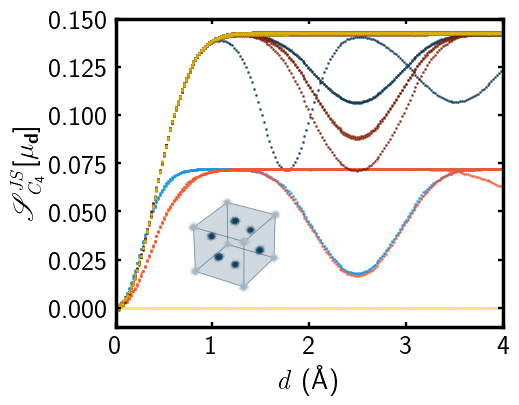

In [ ]:
# center - no label
BLUE_LIGHT, BLUE_DARK = adjust_lightness(BLUE, amount=2.5), adjust_lightness(BLUE, amount=0.9)
RED_LIGHT, RED_DARK = adjust_lightness(RED, amount=1.6), adjust_lightness(RED, amount=0.7)
YELLOW_LIGHT, YELLOW_DARK = adjust_lightness(YELLOW, amount=1.6), adjust_lightness(YELLOW, amount=1.0)
data = {1:{'x': measures_data_center_0_light[:,0], 'y': measures_data_center_0_light[:,1], 'color': BLUE_LIGHT}, 
        2:{'x': measures_data_center_0_dark[:,0], 'y': measures_data_center_0_dark[:,1], 'color': BLUE_DARK}, 
        3:{'x': measures_data_center_45_light[:,0], 'y': measures_data_center_45_light[:,1], 'color': RED_LIGHT}, 
        4:{'x': measures_data_center_45_dark[:,0], 'y': measures_data_center_45_dark[:,1], 'color': RED_DARK}, 
        5:{'x': measures_data_center_90_light[:,0], 'y': measures_data_center_90_light[:,1], 'color': YELLOW_LIGHT}, 
        6:{'x': measures_data_center_90_dark[:,0], 'y': measures_data_center_90_dark[:,1], 'color': YELLOW_DARK}}
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{C}_4}[\mu_\mathbf{d}]$',
     xlim=[0,4], ylim=[-0.01,0.15], 
     filename='../figs/nickel/rotation_center_nolabel.pdf', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_center_nobackground.pdf', 'loc':[0.24, 0.19, 0.25, 0.25]})

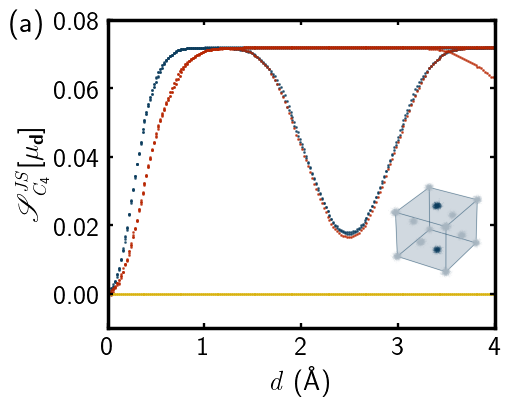

In [29]:
# =========================================================
# Figure (a): only the "light" subsets, colored BLUE/RED/YELLOW
# =========================================================
data_light = {
    1: {
        'x': measures_data_center_0_light[:, 0],
        'y': measures_data_center_0_light[:, 1],
        'color': BLUE,
    },
    2: {
        'x': measures_data_center_45_light[:, 0],
        'y': measures_data_center_45_light[:, 1],
        'color': RED,
    },
    3: {
        'x': measures_data_center_90_light[:, 0],
        'y': measures_data_center_90_light[:, 1],
        'color': YELLOW,
    },
}

plot(
    data_light,
    xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)',
    ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{C}_4}[\mu_\mathbf{d}]$',
    xlim=[0, 4],
    ylim=[-0.01, 0.08],
    filename='../figs/nickel/rotation_center_light.pdf',
    style=bg_mpl_style,
    text={'content': '(a)', 'loc': [-0.07, 0.85, 0, 0]},
    solid={
        'directory': '../figs/nickel/cubic_solid_nickel_samples_top_bottom_nobackground.pdf',
        'loc': [0.66, 0.23, 0.25, 0.25],
    },
)

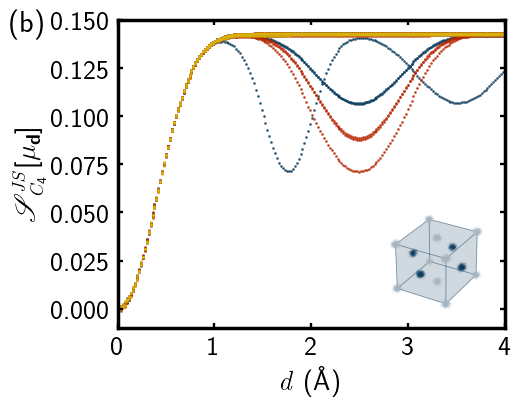

In [30]:
# =========================================================
# Figure (b): only the "dark" subsets, also BLUE/RED/YELLOW
# =========================================================
data_dark = {
    1: {
        'x': measures_data_center_0_dark[:, 0],
        'y': measures_data_center_0_dark[:, 1],
        'color': BLUE,
    },
    2: {
        'x': measures_data_center_45_dark[:, 0],
        'y': measures_data_center_45_dark[:, 1],
        'color': RED,
    },
    3: {
        'x': measures_data_center_90_dark[:, 0],
        'y': measures_data_center_90_dark[:, 1],
        'color': YELLOW,
    },
}

plot(
    data_dark,
    xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)',
    ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{C}_4}[\mu_\mathbf{d}]$',
    xlim=[0, 4],
    ylim=[-0.01, 0.15],
    filename='../figs/nickel/rotation_center_dark.pdf',
    style=bg_mpl_style,
    text={'content': '(b)', 'loc': [-0.09, 0.85, 0, 0]},
    solid={
        'directory': '../figs/nickel/cubic_solid_nickel_samples_side_faces_nobackground.pdf',
        'loc': [0.64, 0.15, 0.25, 0.25],
    },
)

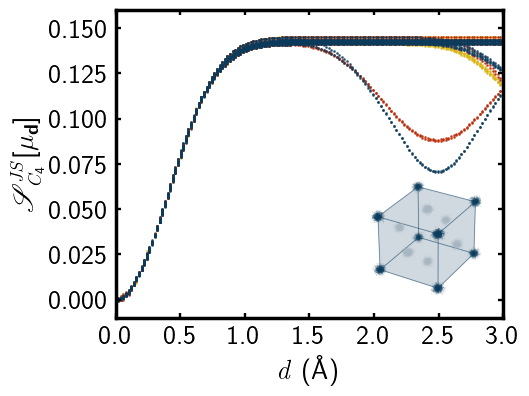

In [21]:
# corner - no label
measures_data_corner_0 = np.array(measures_data_corner_0)
measures_data_corner_45 = np.array(measures_data_corner_45)
measures_data_corner_90 = np.array(measures_data_corner_90)
data = {3:{'x': measures_data_corner_90[:,0], 'y': measures_data_corner_90[:,1], 'color': YELLOW},
        2:{'x': measures_data_corner_45[:,0], 'y': measures_data_corner_45[:,1], 'color': RED},
        1:{'x': measures_data_corner_0[:,0], 'y': measures_data_corner_0[:,1], 'color': BLUE}}
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{C}_4}[\mu_\mathbf{d}]$',
     xlim=[0,3], ylim=[-0.01,0.16], 
     filename='../figs/nickel/rotation_corner_nolabel.pdf', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_corner_nobackground.pdf', 'loc':[0.6, 0.16, 0.3, 0.3]})